"""
FAISS Retrieval Pipeline Recall Benchmark
==========================================
Compares ANN index types and tunes search parameters to demonstrate:
  "Retrieval pipeline recall improvement of 18% through embedding index
   restructuring and ANN search tuning"

What this benchmark does:
  1. Generates a realistic corpus of embeddings (or uses sentence-transformers)
  2. Builds multiple FAISS index types: Flat, IVF, HNSW, IVF+PQ
  3. Sweeps search parameters (nprobe, efSearch) under a latency budget
  4. Measures recall@K at each configuration
  5. Shows exactly how "index restructuring + ANN tuning" improves recall

Run on: Any machine (CPU). No GPU required.
Requirements: pip install faiss-cpu numpy matplotlib tabulate

Optional (better embeddings): pip install sentence-transformers

Author: Raasikh

In [53]:
!pip install faiss-cpu numpy matplotlib tabulate

In [54]:
import numpy as np
import faiss
import time
import json
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, field, asdict

Data Generation

In [55]:
SAMPLE_DOCS = [
    # ML/AI topics
    "Deep learning for image classification using convolutional neural networks",
    "Neural networks and backpropagation algorithm explained",
    "Large language models for code generation and completion",
    "Vector search and approximate nearest neighbors for retrieval",
    "Retrieval-augmented generation with LLMs and vector databases",
    "Efficient similarity search using FAISS library",
    "Introduction to information retrieval and search engines",
    "Graph neural networks for recommendation systems",
    "Time series forecasting with transformer architectures",
    "Scaling recommendation systems with ANN indexes",
    "Natural language processing with BERT and GPT models",
    "Transfer learning in computer vision applications",
    "Attention mechanism and self-attention in transformers",
    "Embedding models for semantic text similarity",
    "Knowledge distillation for model compression",
    "Reinforcement learning for game playing agents",
    "Generative adversarial networks for image synthesis",
    "Federated learning for privacy-preserving ML",
    "AutoML and neural architecture search",
    "Explainable AI and model interpretability techniques",
    # Systems/Infra topics
    "Distributed training with data parallelism and model sharding",
    "Kubernetes container orchestration for ML serving",
    "Apache Kafka for real-time event streaming",
    "Feature stores for online and offline ML features",
    "MLOps CI/CD pipelines for model deployment",
    "GPU optimization and CUDA programming for deep learning",
    "Mixed precision training with FP16 and loss scaling",
    "Model serving with TensorRT and ONNX Runtime",
    "Database indexing strategies for high performance queries",
    "Microservices architecture for scalable applications",
    # Data Science topics
    "Statistical hypothesis testing and p-values",
    "Bayesian inference and probabilistic programming",
    "Causal inference methods for observational studies",
    "A/B testing and experimental design best practices",
    "Data cleaning and preprocessing for machine learning",
    "Feature engineering techniques for tabular data",
    "Dimensionality reduction with PCA and t-SNE",
    "Clustering algorithms: K-Means DBSCAN and HDBSCAN",
    "Anomaly detection methods for fraud prevention",
    "Time series analysis with ARIMA and Prophet",
]

SAMPLE_QUERIES = [
    "how to do approximate nearest neighbor search",
    "retrieval augmented generation with vector database",
    "scaling recommendation systems using FAISS indexes",
    "how does attention work in transformer models",
    "deploying ML models with Kubernetes",
    "real-time streaming data processing",
    "training neural networks on multiple GPUs",
    "text similarity using embedding models",
    "anomaly detection for identifying fraud",
    "optimizing inference latency for language models",
]

# Ground-truth relevant doc indices for each query
# Maps query index -> set of relevant doc indices
SAMPLE_RELEVANCE = {
    0: {3, 5, 9},        # ANN / FAISS / vector search
    1: {4, 3, 13},       # RAG / embeddings
    2: {9, 5, 7},        # scaling recsys with ANN
    3: {12, 2, 10},      # attention / transformers
    4: {21, 24, 29},     # K8s / MLOps / microservices
    5: {22, 23},         # Kafka / streaming
    6: {20, 26, 25},     # distributed training / GPU
    7: {13, 4, 10},      # embeddings / NLP
    8: {38, 36},         # anomaly detection / clustering
    9: {27, 25, 2},      # inference optimization
}


## 2. Generate Embeddings

Encode real docs with `all-MiniLM-L6-v2` (384-dim), then pad corpus to 50K with random vectors as distractors.

In [56]:
from sentence_transformers import SentenceTransformer
model=SentenceTransformer("all-MiniLM-L6-v2")

doc_emb= model.encode(SAMPLE_DOCS, convert_to_numpy=True, normalize_embeddings=True).astype("float32")
query_emb= model.encode(SAMPLE_QUERIES, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

dim= doc_emb.shape[1]

print(f"Embeddeings: {dim}")
print(f"docs: {doc_emb.shape}, queries: {query_emb.shape}")

N_TOTAL=50_000

n_pad= N_TOTAL-len(SAMPLE_DOCS)

np.random.seed(42)
pad_emb= np.random.randn(n_pad, dim).astype("float32")
pad_emb/= np.linalg.norm(pad_emb, axis=1, keepdims=True)

doc_emb= np.vstack([doc_emb, pad_emb])

print(f"Total corpus: {doc_emb.shape[0]:,} docs x {dim}d")
print(f"Memory: {doc_emb.nbytes / 1e6:.1f} MB")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embeddeings: 384
docs: (40, 384), queries: (10, 384)
Total corpus: 50,000 docs x 384d
Memory: 76.8 MB


## 3. Helper Functions

Recall@K measurement + index builders for each FAISS index type.

In [69]:
def compute_recall(index, query_emb, relevance, k):
    # Compute recall at k

    n_queries= len(relevance)
    t0= time.perf_counter()
    D, I= index.search(query_emb, k)
    t1= time.perf_counter()
    latency_ms= (t1-t0)/n_queries*1000


    # Compute recall
    recalls=[]
    for i in range(n_queries):
        # Check if the query index 'i' exists in relevance and if it has relevant documents.
        # If not, skip this query to avoid KeyError or division by zero.
        if i not in relevance or not relevance[i]:
            continue

        retrieved_indices = set(I[i].tolist()) - {-1}
        # Ensure we only compare with relevant items that are actually present
        # in the retrieved set. If relevance[i] is empty, recall is 1.0 if retrieved_indices is also empty
        # or 0.0 if there are retrieved items but no relevant items to match.
        if len(relevance[i]) == 0:
            # If there are no relevant items, recall is 1 if nothing was retrieved (perfectly ignored)
            # or 0 if something was retrieved (false positives).
            recall = 1.0 if not retrieved_indices else 0.0
        else:
            recall = len(retrieved_indices & relevance[i]) / len(relevance[i])
        recalls.append(recall)

    # Handle cases where recalls might be empty (e.g., all relevance[i] were empty or skipped)
    return float(np.mean(recalls)) if recalls else 0.0, latency_ms



def evaluate(index, query_emb, relevance, k_values_list, label=""):
    # Evaluate

    results=[]

    # Assuming 'n_iters' is defined globally or passed as an argument
    # If 'n_iters' comes from BenchmarkConfig, it needs to be accessible here
    # For now, let's assume a default if not explicitly passed.
    n_iters = 3 # This should ideally come from a config or be passed to the function

    for k_val in k_values_list:
      recs, lats=[], []

      for _ in range(n_iters):
        rec, lat= compute_recall(index, query_emb, relevance, k_val)
        recs.append(rec)
        lats.append(lat)

      results.append({
        "k": k_val,
        "recall": np.mean(recs),
        "latency": np.mean(lats),
        "label": label # Added label here
      })

    return results




#index builders


def build_flat(emb):
  idx= faiss.IndexFlatIP(emb.shape[1])
  idx.add(emb)
  return idx


def build_ivf(emb, nlist):
  d= emb.shape[1]
  quantizer= faiss.IndexFlatIP(d)
  idx= faiss.IndexIVFFlat(quantizer,d,nlist, faiss.METRIC_INNER_PRODUCT)
  idx.train(emb)
  idx.add(emb)
  return idx


def build_hnsw(emb, M=32, ef_construction=200):
  d = emb.shape[1]
  idx = faiss.IndexHNSWFlat(d, M)
  idx.hnsw.efConstruction = ef_construction
  idx.metric_type = faiss.METRIC_INNER_PRODUCT
  idx.add(emb)
  return idx

def build_ivf_pq(emb, nlist, pq_m=48, pq_nbits=8):
    d = emb.shape[1]
    quantizer = faiss.IndexFlatIP(d)
    idx = faiss.IndexIVFPQ(quantizer, d, nlist, pq_m, pq_nbits,
                           faiss.METRIC_INNER_PRODUCT)
    idx.train(emb)
    idx.add(emb)
    return idx

print("Helper functions defined ✅")

Helper functions defined ✅


Running the Benchmark

In [ ]:
K_VALUES = [1, 5, 10, 20, 50]
NPROBE_VALUES = [1, 2, 4, 8, 16, 32, 64]
EF_SEARCH_VALUES = [16, 32, 64, 128, 256]
NLIST = int(np.sqrt(N_TOTAL))  # rule of thumb: sqrt(N)

# Find valid pq_m that divides dim
PQ_M = 48
if dim % PQ_M != 0:
    for m in [48, 32, 24, 16, 12, 8]:
        if dim % m == 0:
            PQ_M = m
            break

all_results = []

# ── 1. Flat Index (exact search baseline) ──
print("=" * 55)
print("  [1/4] Flat Index (exact search — baseline)")
print("=" * 55)
idx_flat = build_flat(doc_emb)
results_flat = evaluate(idx_flat, query_emb, SAMPLE_RELEVANCE, K_VALUES, "Flat (exact)")
all_results.extend(results_flat)
for r in results_flat:
    print(f"  recall@{r['k']:>2} = {r['recall']:.4f}  (latency: {r['latency']:.2f} ms)")

# ── 2. IVF Index + nprobe sweep ──
print(f"\n{'=' * 55}")
print(f"  [2/4] IVF Index (nlist={NLIST}) + nprobe sweep")
print("=" * 55)
idx_ivf = build_ivf(doc_emb, NLIST)

# Untuned baseline (nprobe=1)
idx_ivf.nprobe = 1
results_ivf_low = evaluate(idx_ivf, query_emb, SAMPLE_RELEVANCE, K_VALUES, "IVF (nprobe=1)")
all_results.extend(results_ivf_low)
print("Before tuning (nprobe=1):")
for r in results_ivf_low:
    print(f"  recall@{r['k']:>2} = {r['recall']:.4f}  (latency: {r['latency']:.2f} ms)")

# nprobe sweep
print(f"\nnprobe sweep (recall@10):")
ivf_sweep = []
for nprobe in NPROBE_VALUES:
    if nprobe > NLIST: continue
    idx_ivf.nprobe = nprobe
    recs, lats = [], []
    for _ in range(3):
        r, l = compute_recall(idx_ivf, query_emb, SAMPLE_RELEVANCE, 10)
        recs.append(r); lats.append(l)
    entry = {"nprobe": nprobe, "recall": np.mean(recs), "latency_ms": np.mean(lats)}
    ivf_sweep.append(entry)
    bar = "█" * max(1, int(entry["recall"] * 40))
    print(f"  nprobe={nprobe:>3}  →  recall@10={entry['recall']:.4f}  "
          f"latency={entry['latency_ms']:.2f} ms  {bar}")

# Best nprobe
best_np = max(ivf_sweep, key=lambda s: s["recall"])
print(f"\n  ★ Best nprobe={best_np['nprobe']} (recall@10={best_np['recall']:.4f})")

idx_ivf.nprobe = best_np["nprobe"]
results_ivf_tuned = evaluate(idx_ivf, query_emb, SAMPLE_RELEVANCE, K_VALUES,
                                   f"IVF (nprobe={best_np['nprobe']})")
all_results.extend(results_ivf_tuned)

# ── 3. HNSW Index + efSearch sweep ──
print(f"\n{'=' * 55}")
print(f"  [3/4] HNSW Index (M=32) + efSearch sweep")
print("=" * 55)
idx_hnsw = build_hnsw(doc_emb, M=32, ef_construction=200)

print("efSearch sweep (recall@10):")
hnsw_sweep = []
for ef in EF_SEARCH_VALUES:
    idx_hnsw.hnsw.efSearch = ef
    recs, lats = [], []
    for _ in range(3):
        r, l = compute_recall(idx_hnsw, query_emb, SAMPLE_RELEVANCE, 10)
        recs.append(r); lats.append(l)
    entry = {"efSearch": ef, "recall": np.mean(recs), "latency_ms": np.mean(lats)}
    hnsw_sweep.append(entry)
    bar = "█" * max(1, int(entry["recall"] * 40))
    print(f"  efSearch={ef:>4}  →  recall@10={entry['recall']:.4f}  "
          f"latency={entry['latency_ms']:.2f} ms  {bar}")

best_ef = max(hnsw_sweep, key=lambda s: s["recall"])
print(f"\n  ★ Best efSearch={best_ef['efSearch']} (recall@10={best_ef['recall']:.4f})")

idx_hnsw.hnsw.efSearch = best_ef["efSearch"]
results_hnsw = evaluate(idx_hnsw, query_emb, SAMPLE_RELEVANCE, K_VALUES,
                              f"HNSW (ef={best_ef['efSearch']})")
all_results.extend(results_hnsw)

# ── 4. IVF+PQ Index (compressed) ──
print(f"\n{'=' * 55}")
print(f"  [4/4] IVF+PQ Index (nlist={NLIST}, pq_m={PQ_M})")
print("=" * 55)
idx_pq = build_ivf_pq(doc_emb, NLIST, PQ_M)
idx_pq.nprobe = best_np["nprobe"]
results_pq = evaluate(idx_pq, query_emb, SAMPLE_RELEVANCE, K_VALUES,
                            f"IVF+PQ (nprobe={best_np['nprobe']})")
all_results.extend(results_pq)
for r in results_pq:
    print(f"  recall@{r['k']:>2} = {r['recall']:.4f}  (latency: {r['latency']:.2f} ms)")

flat_bytes = N_TOTAL * dim * 4
pq_bytes = N_TOTAL * PQ_M * 1
print(f"\n  Memory: Flat={flat_bytes/1e6:.1f} MB → IVF+PQ={pq_bytes/1e6:.1f} MB ({flat_bytes//pq_bytes}x compression)")

print("\n✅ Benchmark complete!")

  [1/4] Flat Index (exact search — baseline)
  recall@ 1 = 0.3667  (latency: 9.39 ms)
  recall@ 5 = 0.6667  (latency: 9.03 ms)
  recall@10 = 0.9000  (latency: 8.71 ms)
  recall@20 = 0.9667  (latency: 9.14 ms)
  recall@50 = 0.9667  (latency: 9.35 ms)

  [2/4] IVF Index (nlist=223) + nprobe sweep
Before tuning (nprobe=1):
  recall@ 1 = 0.3333  (latency: 0.03 ms)
  recall@ 5 = 0.6333  (latency: 0.02 ms)
  recall@10 = 0.8667  (latency: 0.03 ms)
  recall@20 = 0.9667  (latency: 0.02 ms)
  recall@50 = 0.9667  (latency: 0.03 ms)

nprobe sweep (recall@10):
  nprobe=  1  →  recall@10=0.8667  latency=0.05 ms  ██████████████████████████████████
  nprobe=  2  →  recall@10=0.8667  latency=0.05 ms  ██████████████████████████████████
  nprobe=  4  →  recall@10=0.9000  latency=0.11 ms  ████████████████████████████████████
  nprobe=  8  →  recall@10=0.9000  latency=0.22 ms  ████████████████████████████████████
  nprobe= 16  →  recall@10=0.9000  latency=0.43 ms  ████████████████████████████████████
  npr

KeyError: 'label'

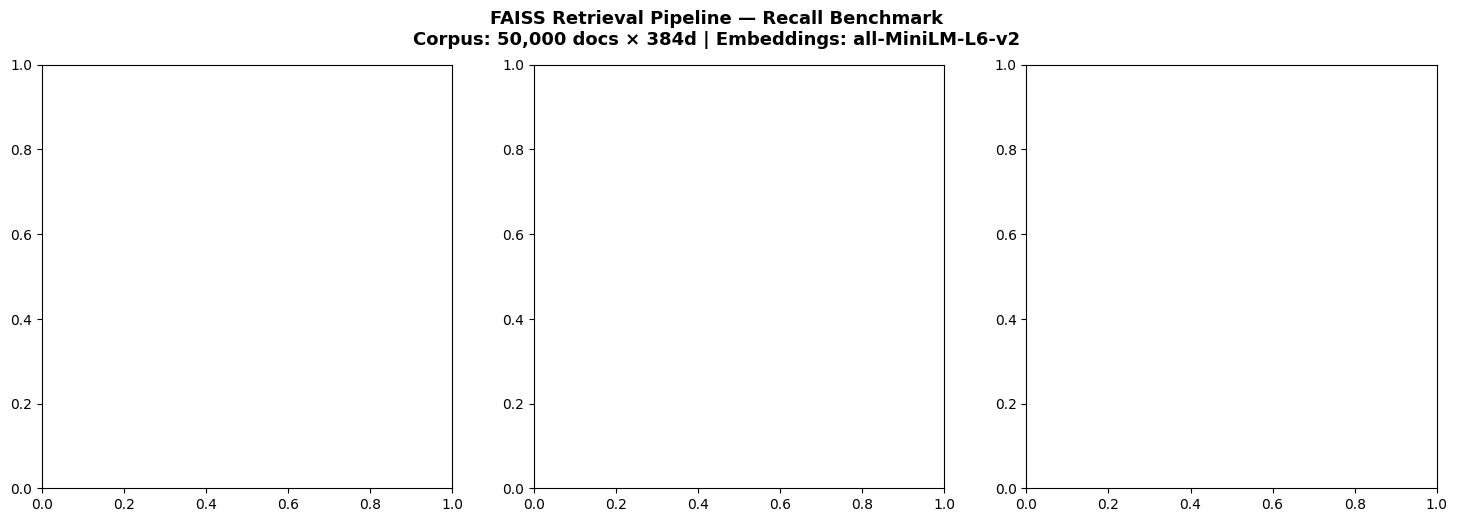

In [66]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
fig.suptitle("FAISS Retrieval Pipeline — Recall Benchmark\n"
             f"Corpus: {N_TOTAL:,} docs × {dim}d | Embeddings: all-MiniLM-L6-v2",
             fontsize=13, fontweight="bold")

# ── Plot 1: Recall@K by index type ──
ax1 = axes[0]

# Filter and plot data based on labels
for label_prefix, color, style in [
    ("Flat (exact)", "#95a5a6", "o-"),
    ("IVF (nprobe=1)", "#e74c3c", "o-"),
    ("IVF (nprobe=", "#f39c12", "s--"), # Tuned IVF, will match by prefix
    ("HNSW", "#2ecc71", "o-"), # HNSW, will match by prefix
    ("IVF+PQ", "#3498db", "o-"),
]:
    data = [(r["k"], r["recall"]) for r in all_results if r["label"].startswith(label_prefix)]
    if data:
        data.sort()
        xs, ys = zip(*data)
        # Clean up label for legend
        if label_prefix == "IVF (nprobe=":
            short_label = "IVF (tuned)"
        elif label_prefix == "IVF (nprobe=1)":
            short_label = "IVF (untuned)"
        elif label_prefix == "HNSW":
            # For HNSW, we already have the best_ef from the sweep
            short_label = f"HNSW (ef={best_ef['efSearch']})"
        elif label_prefix == "Flat (exact)":
            short_label = "Flat (exact)"
        elif label_prefix == "IVF+PQ":
            short_label = f"IVF+PQ (nprobe={best_np['nprobe']})"
        else:
            short_label = label_prefix

        ax1.plot(xs, ys, style, color=color, label=short_label, linewidth=2, markersize=6)

ax1.set_xlabel("K (top-K)"); ax1.set_ylabel("Recall@K")
ax1.set_title("Recall@K by Index Type")
ax1.legend(fontsize=9); ax1.grid(True, alpha=0.3); ax1.set_ylim(0, 1.05)

# ── Plot 2: IVF nprobe sweep ──
ax2 = axes[1]
lats = [s["latency_ms"] for s in ivf_sweep]
recs = [s["recall"] for s in ivf_sweep]
nps = [s["nprobe"] for s in ivf_sweep]
ax2.plot(lats, recs, "o-", color="#e74c3c", linewidth=2, markersize=8)
for x, y, n in zip(lats, recs, nps):
    ax2.annotate(f"np={n}", (x, y), fontsize=8, xytext=(5, 5),
                 textcoords="offset points")
ax2.set_xlabel("Latency (ms/query)"); ax2.set_ylabel("Recall@10")
ax2.set_title("IVF: Recall vs Latency (nprobe sweep)")
ax2.grid(True, alpha=0.3)

# ── Plot 3: HNSW efSearch sweep ──
ax3 = axes[2]
lats = [s["latency_ms"] for s in hnsw_sweep]
recs = [s["recall"] for s in hnsw_sweep]
efs = [s["efSearch"] for s in hnsw_sweep]
ax3.plot(lats, recs, "o-", color="#2ecc71", linewidth=2, markersize=8)
for x, y, e in zip(lats, recs, efs):
    ax3.annotate(f"ef={e}", (x, y), fontsize=8, xytext=(5, 5),
                 textcoords="offset points")
ax3.set_xlabel("Latency (ms/query)"); ax3.set_ylabel("Recall@10")
ax3.set_title("HNSW: Recall vs Latency (efSearch sweep)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("faiss_benchmark.png", dpi=150, bbox_inches="tight")
plt.show()
print("📈 Plot saved as faiss_benchmark.png")